##Датасет взят с сайта: https://www1.nyc.gov/html/gbee/html/plan/ll84_scores.shtml

## построить модель используя LinearRegression для предсказания энергопотребления зданий в Нью-Йорке;

использовать иснтруметы нормализации/стандартизации признаков;

использовать по крайней мере один из способов отбора признаков (см. блокнот с вебинара).

##построить модель используя LinearRegression, LinearSVR для предсказания энергопотребления зданий в Нью-Йорке;

произвести нормализацию признаков в случае необходимости;

использовать все инструменты для отбора признаков;


In [1]:
import numpy as np
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import shapiro
from scipy.stats import normaltest
from IPython.core.pylabtools import figsize
import seaborn as sns
from sklearn.model_selection import train_test_split
from IPython.core.pylabtools import figsize
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.svm import LinearSVR
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Создал функцию для удобства просмотра

In [3]:
## Просмотр данных
def prosmotr(data):
  pd.set_option('display.max_columns', 100) #Размеры таблицы
  pd.set_option('display.max_rows', 100)
  pd.set_option('precision', 2) #Регулируем количество знаков после запятой:
  print('~~~~Содержание данных~~~~\n', data.head())
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  print('~~~Размеры данных~~~\n', data.shape)
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  print('~~~Названия колонок~~~\n', data.columns)
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  print('~~~Информация о данных~~~\n')
  print(data.info())
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  print('~~~Наличие пропусков в данных~~~\n', data.isna().sum())
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  print('~~~Количество типов в данных~~~')
  print(data.dtypes.value_counts())
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  kateg = list(data.select_dtypes(include=['object']).columns) # Делаем список категориальных данных
  print('~~~Категориальные данные~~~~')
  print(kateg)
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  chislov_float = list(data.select_dtypes(include=['float64'])) #Делаем список числовых данных float
  print('~~~Числове данные float~~~~')
  print(chislov_float)
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  chislov_int = list(data.select_dtypes(include=['int64'])) #Делаем список числовых данных int
  print('~~~Числове данные int~~~~')
  print(chislov_int)
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  print('~~~Основные статистические характеристики данных по каждому числовому признаку (типы int64)~~~\n', data.describe(include=['int64']))
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  print('~~~Основные статистические характеристики данных по каждому числовому признаку (типы float64)~~~\n', data.describe(include=['float64']))
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  print('~~~Cтатистика по нечисловым признакам object ~~~\n', data.describe(include=['object']))
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
#  print('~~~Cтатистика по нечисловым признакам bool ~~~\n', data.describe(include=['bool'])) этих данных просто нет в наборе данных
#  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

 

In [4]:
## Анализ данных
def analyze(data):
  num = data.columns
  for i in num:
    print(i.title())
    print('~~~~~~~~~~~~~~~~~~~~~~~~~\n')
    print("mean : ", np.mean(data[i]))
    print("var  : ", np.var(data[i]))
    print("skew : ", skew(data[i]))
    print("kurt : ", kurtosis(data[i]))
    print("shapiro : ", shapiro(data[i]))
    print("normaltest : ", normaltest(data[i]))
    print('~~~~~~~~~~~~~~~~~~~~~~~~~')
    print('~~~~~~~~~~~~~~~~~~~~~~~~~\n')


## Функции для работы с данными

In [5]:
## функция для просмотра пропусков в данных

def values_table_null(data):
        # всего пропусков
        mis_val = data.isnull().sum()
        
        # процент пропусков
        mis_val_percent = 100 * data.isnull().sum() / len(data)
        
        # Делаем таблицу с получившимися результатами
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Переименовать столбцы
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Сортировка таблицы по проценту пропущенных по убыванию
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Выввод на печать сводную информацию
        print ("Выбранныей Вами данные " + str(data.shape[1]) + " колонок.\n"      
            "Из них " + str(mis_val_table_ren_columns.shape[0]) +
              " имеют пропуск")      

        return mis_val_table_ren_columns

## Функции по алгоритмам

In [6]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV


def fit_model(model, X, y, parameters):  
  cross_validation = StratifiedKFold(n_splits=5)

  grid_search = GridSearchCV(model,
                              scoring='accuracy',
                              param_grid=parameters,
                              cv=cross_validation,
                              verbose=1
                            )

  grid_search.fit(X, y)
  parameters=grid_search.best_params_
  print('Best score: {}'.format(grid_search.best_score_))
  print('Best parameters: {}'.format(parameters))

  return grid_search

### Чтение из файла и первичный анализ

In [42]:
df= pd.read_csv('/content/drive/My Drive/dataset/energy/Energy_and_Water_Data_Disclosure_for_Local_Law_84_2017__Data_for_Calendar_Year_2016_.csv')

In [43]:
prosmotr(df)

~~~~Содержание данных~~~~
    Order  Property Id                                 Property Name  \
0      1        13286                                       201/205   
1      2        28400                    NYP Columbia (West Campus)   
2      3      4778226                                 MSCHoNY North   
3      4      4778267  Herbert Irving Pavilion & Millstein Hospital   
4      5      4778288                               Neuro Institute   

  Parent Property Id        Parent Property Name BBL - 10 digits  \
0              13286                     201/205      1013160001   
1              28400  NYP Columbia (West Campus)      1021380040   
2              28400  NYP Columbia (West Campus)      1021380030   
3              28400  NYP Columbia (West Campus)      1021390001   
4              28400  NYP Columbia (West Campus)      1021390085   

  NYC Borough, Block and Lot (BBL) self-reported  \
0                                     1013160001   
1                                

In [9]:
df.head(3)

,Order,Property Id,Property Name,Parent Property Id,Parent Property Name,BBL - 10 digits,"NYC Borough, Block and Lot (BBL) self-reported",NYC Building Identification Number (BIN),Address 1 (self-reported),Address 2,Postal Code,Street Number,Street Name,Borough,DOF Gross Floor Area,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft²),2nd Largest Property Use Type,2nd Largest Property Use - Gross Floor Area (ft²),3rd Largest Property Use Type,3rd Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,Metered Areas (Energy),Metered Areas (Water),ENERGY STAR Score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Source EUI (kBtu/ft²),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),District Steam Use (kBtu),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Water Use (All Water Sources) (kgal),Water Intensity (All Water Sources) (gal/ft²),Source EUI (kBtu/ft²),Release Date,Water Required?,DOF Benchmarking Submission Status,Latitude,Longitude,Community Board,Council District,Census Tract,NTA
0,1,13286,201/205,13286,201/205,1013160001,1013160001,1037549,201/205 East 42nd st.,Not Available,10017,675,3 AVENUE,Manhattan,2.89e+05,Office,Office,Office,293447,Not Available,Not Available,Not Available,Not Available,1963,2,100,Whole Building,Not Available,Not Available,305.6,303.1,37.8,Not Available,614.2,Not Available,Not Available,Not Available,Not Available,Not Available,5.15506751E7,Not Available,Not Available,38139374.2,1.10827705E7,6962.2,0,6962.2,762051,Not Available,Not Available,619.4,05/01/2017 05:32:03 PM,No,In Compliance,40.75,-73.97,6.0,4.0,88.0,Turtle Bay-East Midtown ...
1,2,28400,NYP Columbia (West Campus),28400,NYP Columbia (West Campus),1021380040,1-02138-0040,1084198; 1084387;1084385; 1084386; 1084388; 10...,622 168th Street,Not Available,10032,180,FT WASHINGTON AVENUE,Manhattan,3.69e+06,Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),3889181,Not Available,Not Available,Not Available,Not Available,1969,12,100,Whole Building,Whole Building,55,229.8,228.8,24.8,2.4,401.1,Not Available,1.96248472E7,Not Available,Not Available,Not Available,-3.914148026E8,933073441,9330734.4,332365924,9.62613121E7,55870.4,51016.4,4854.1,3889181,Not Available,Not Available,404.3,04/27/2017 11:23:27 AM,No,In Compliance,40.84,-73.94,12.0,10.0,251.0,Washington Heights South ...
2,3,4778226,MSCHoNY North,28400,NYP Columbia (West Campus),1021380030,1-02138-0030,1063380,3975 Broadway,Not Available,10032,3975,BROADWAY,Manhattan,1.53e+05,Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),231342,Not Available,Not Available,Not Available,Not Available,1924,1,100,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,0,0,0,231342,Not Available,Not Available,Not Available,04/27/2017 11:23:27 AM,No,In Compliance,40.84,-73.94,12.0,10.0,251.0,Washington Heights South ...


## Нашел описание каждого признака
http://www.nyc.gov/html/gbee/downloads/misc/nyc_benchmarking_disclosure_data_definitions_2017.pdf

## Order	
  Заказ BBL на раскрытие данных
## Property Id
  Номер, присвоенный каждому представлению бенчмаркинга портфельный
	менеджер. Это значение является уникальным для каждой записи,
	представленной в поле BBL. Обратите внимание, что если бы не было никакого
	представления бенчмаркинг получили Департамент финансов, то нет назначена	
	запись номера в столбце.
	
## Property Name	
  Основная информация о недвижимости включает в себя имя свойства.

## Parent Property Id
  Идентификатор для кампуса упоминается как родитель ID недвижимости
	
## Parent Property Name
	Когда вы тест кампус (или набор зданий) вы можете отслеживать
	информацию по всей территории кампуса, а также для отдельных
	зданий на территории кампуса. Если вы хотите отслеживать на обоих
	этих уровнях, то есть «родитель-потомок». «Родитель» является всем
	кампусом или сложным. То есть, родитель мульти-здание	собственность,
  для которого вы также выбрали для тестов отдельных
	зданий отдельно.
	
## BBL - 10 digits
  10-значное свойство р-н, блок и идентификатор много, первоначально
	введенная в поле «Стандартные идентификаторы» в Portfolio Manager, а
	затем проверяется и корректируется, по мере необходимости, Департамент
	финансов (DOF). Первое число представляет собой р-н, где 1 Manhattan, 2
	Бронкс, Бруклин 3, 4 Квинс, и 5 Статен-Айленд. Следующие пяти цифр
	представляют налоговый блок. Если свойство имеет налоговый блок,
	который меньше, чем 5 цифр, то нули добавляются перед номером блока,
	так что пяти цифр в целом. Последние четыре цифры являются номером
	налога много.
  
## NYC Borough, Block and Lot (BBL) self-	
	10-значное свойство р-н, блок и идентификатор много, selfreported

## NYC Building Identification Number (BIN))		
  Самоотчеты семизначный идентификационный номер здания.
					
## Address 1 (self-reported)		
  Улица 1 (самооценка)	
  
## Address 2	
  Улица 2 (самооценка)	
  
## Postal Code
  Почтовый индекс для недвижимости, сообщает самостоятельно
				
## Street Number
  Номер дома на имущество, за DOF записей.

## Street Name
  Название улицы за собственность, за DOF записей.

## Borough
  Местечко на имущество, за DOF записей.			

## DOF Gross Floor Area
  Брутто площадь участка имущества, за DOF записей.

## Primary Property Type - Self Selected	
  Самоотчеты варианта типа недвижимости, доступная в диспетчере Portfolio.
  
## List of All Property Use Types at Property	
  Разделенный запятыми список всех типов свойств для одного
		свойства, в алфавитном порядке.			
					
## Largest Property Use Type
  Название Тип собственности (например: Office), который имеет самую большую
		площадь брутто (GFA) для этого свойства.			
										
## Largest Property Use Type - Gross Floor Area (ft²)
  GFA для крупнейшего Тип недвижимости.			

## 2nd Largest Property Use Type
  Название Тип собственности (например: Office), который имеет второй по
		величине GFA для этого свойства.			
										
## 2nd Largest Property Use - Gross Floor Area (ft²)
  GFA для второго по величине Типа недвижимости.			

## 3rd Largest Property Use Type		
  Название Тип собственности (например: Office), который имеет третий по
		величине GFA для этого свойства.			
					
## 3rd Largest Property Use Type - Gross Floor Area (ft²)	
  GFA для третьего по величине Типа недвижимости.			

## Year Built
		Это год, в котором была построена ваша собственность. Если ваша
		собственность подверглась полной реконструкции, которая включала
		потрошения и восстановление интерьера, то вы можете указать дату
		этого обновления в год построен. Если вы не знаете точный год свойство
		было построено, введите оценку.			
				
## Number of Buildings - Self-reported
  Количество зданий показывает общее количество зданий, которые
		расположены на налоговый жребию.			
				
## Occupancy
  Процент Gross площадь вашего имущества (GFA),
		занимаемый и работоспособны.			
					
## Metered Areas (Energy)	
  Измеренный Areas этого обозначения того, что районы в пределах вашего
		здания покрыты ваши энергии и счетчики воды.			
					
## Metered Areas (Water)
  Измеренный Areas этого обозначения того, что районы в пределах вашего
		здания покрыты ваши энергии и счетчики воды.			

## ENERGY STAR Score
		1-к-100 процентиля ранжирования для определенных типов зданий,
		рассчитанных в Portfolio Manager, на основе самооценки потребления
		энергии за отчетный год.	
    
## Site EUI (kBtu/ft²)
		Интенсивность использования энергии, что рассчитывается менеджером
		портфеля на сайте недвижимости в kBtus на валовой квадратный фут (КБТУ /
		ft2), за отчетный год.			
				
## Weather Normalized Site EUI (kBtu/ft²)	
  Интенсивность использования энергии, что рассчитывается по Portfolio Manager
		на сайте недвижимости в kBtus за квадратный фут брутто
## ENERGY STAR Score		
  (КБТ / ft2) за отчетный год, нормализует погоды.

## Weather Normalized Site Electricity	Intensity (kWh/ft²)
  Погода Нормированная сайта Энергия делится на размер имущества	
	или с помощью потока через станцию очистки воды / сточных вод.
		
## Weather Normalized Site Natural Gas Intensity (therms/ft²)		
  Погода Нормированная сайта Энергия делится на размер имущества	
		или с помощью потока через станцию очистки воды / сточных вод.

## Weather Normalized Source EUI (kBtu/ft²)					
		Энергоемкость использование, рассчитанный Portfolio Manager на	
		источнике генерации энергии в kBtus на валовой квадратный фут (КБТ /	
		ft2) за отчетный год, нормализуют погоды.	
			
## Fuel Oil #1 Use (kBtu)					
		Использование энергии по типу представляет собой резюме ежегодного	
	потребления отдельного вида энергии. Годовые итоговые данные доступны	
		для топочного мазута № 1.	
## Fuel Oil #2 Use (kBtu)				
		Использование энергии по типу представляет собой резюме ежегодного	
		потребления отдельного вида энергии. Годовые итоговые данные доступны	
		для топочного мазута № 2.	
## Fuel Oil #4 Use (kBtu)				
		Использование энергии по типу представляет собой резюме ежегодного	
		потребления отдельного вида энергии. Годовые итоговые данные доступны	
		для топочного мазута № 4.	
## Fuel Oil #5 & 6 Use (kBtu))				
		Использование энергии по типу представляет собой резюме ежегодного	
		потребления отдельного вида энергии. Годовые итоговые данные доступны	
		для мазутного № 5 и 6.	
## Diesel #2 Use (kBtu)				
		Использование энергии по типу представляет собой резюме ежегодного	
		потребления отдельного вида энергии. Годовые суммы доступны для	
		дизельного топлива # 2.	
## District Steam Use (kBtu))				
		Использование энергии по типу представляет собой резюме ежегодного	
		потребления отдельного вида энергии. Годовые итоговые данные доступны	
		для района Steam.	
## Natural Gas Use (kBtu)				
		Использование энергии по типу представляет собой резюме ежегодного	
		потребления отдельного вида энергии. Годовые суммы доступны для	
		природного газа.	
				
## Weather Normalized Site Natural Gas Use	(therms)	
    Энергия использовать свойство потребляла бы в течение	
		30-летнего среднего погодных условий	
## Electricity Use - Grid Purchase (kBtu)
    Использование энергии по типу представляет собой резюме ежегодного	
		потребления отдельного вида энергии. Годовые суммы доступны для	
		использования электроэнергии - Сетка Purchase.	
				
## Weather Normalized Site Electricity (kWh)		
    Энергия использовать свойство потребляла бы в течение	
		30-летнего среднего погодных условий	
## Total GHG Emissions (Metric Tons CO2e)			
		Суммарные прямые и косвенные парниковые газы, испускаемые	
		собственностиCO2e)	, сообщили в метрических тоннах эквивалента двуокиси	
		углерода (MtCO2e) за отчетный год.
## Direct GHG Emissions (Metric Tons CO2e)    
		Суммарные прямые парниковые газы, испускаемые собственности,	
		сообщили в метрических тоннах эквивалента двуокиси углерода	
		(MtCO2e) за отчетный год.	
## Indirect GHG Emissions (Metric Tons CO2e)    
		Суммарные косвенные парниковые газы, испускаемые собственности,	
		сообщили в метрических тоннах эквивалента двуокиси углерода	
		(MtCO2e) за отчетный год.	
## Property GFA - Self-Reported (ft²)	
    Самоотчетам Совокупная площадь участка (ft2) имущества.				
		
## Water Use (All Water Sources) (kgal)	
    Сумма всех счетчиков воды.	

## Water Intensity (All Water Sources)	(gal/ft²)		
    N / A	
## Source EUI (kBtu/ft²)		
	Интенсивность использования энергии, что рассчитывается портфельный	
	менеджер источника генерации энергии в kBtus на валовой квадратный фут	
	(КБТУ / ft2), за отчетный год.		
		
## Release Date	
  Дата представления был выпущен через портфель Сити	
	Управление шаблон.		
## Water Required?			
	Указывает, что свойство имел право использовать данные	
	бенчмаркинга воды, загруженные Департаментом охраны	
	окружающей среды.		
## Zip Code	
  Почтовый индекс для имущества, за DOF записей.	





## Посмотрим пропуски

In [10]:
values_table_null(df)

Выбранныей Вами данные 60 колонок.
Из них 13 имеют пропуск


,Missing Values,% of Total Values
Latitude,2263,19.3
Longitude,2263,19.3
Community Board,2263,19.3
Council District,2263,19.3
Census Tract,2263,19.3
NTA,2263,19.3
Street Number,124,1.1
Street Name,122,1.0
Borough,118,1.0
DOF Gross Floor Area,118,1.0


In [11]:
df.head()

,Order,Property Id,Property Name,Parent Property Id,Parent Property Name,BBL - 10 digits,"NYC Borough, Block and Lot (BBL) self-reported",NYC Building Identification Number (BIN),Address 1 (self-reported),Address 2,Postal Code,Street Number,Street Name,Borough,DOF Gross Floor Area,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft²),2nd Largest Property Use Type,2nd Largest Property Use - Gross Floor Area (ft²),3rd Largest Property Use Type,3rd Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,Metered Areas (Energy),Metered Areas (Water),ENERGY STAR Score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Source EUI (kBtu/ft²),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),District Steam Use (kBtu),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Water Use (All Water Sources) (kgal),Water Intensity (All Water Sources) (gal/ft²),Source EUI (kBtu/ft²),Release Date,Water Required?,DOF Benchmarking Submission Status,Latitude,Longitude,Community Board,Council District,Census Tract,NTA
0,1,13286,201/205,13286,201/205,1013160001,1013160001,1037549,201/205 East 42nd st.,Not Available,10017,675,3 AVENUE,Manhattan,2.89e+05,Office,Office,Office,293447,Not Available,Not Available,Not Available,Not Available,1963,2,100,Whole Building,Not Available,Not Available,305.6,303.1,37.8,Not Available,614.2,Not Available,Not Available,Not Available,Not Available,Not Available,5.15506751E7,Not Available,Not Available,38139374.2,1.10827705E7,6962.2,0,6962.2,762051,Not Available,Not Available,619.4,05/01/2017 05:32:03 PM,No,In Compliance,40.75,-73.97,6.0,4.0,88.0,Turtle Bay-East Midtown ...
1,2,28400,NYP Columbia (West Campus),28400,NYP Columbia (West Campus),1021380040,1-02138-0040,1084198; 1084387;1084385; 1084386; 1084388; 10...,622 168th Street,Not Available,10032,180,FT WASHINGTON AVENUE,Manhattan,3.69e+06,Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),3889181,Not Available,Not Available,Not Available,Not Available,1969,12,100,Whole Building,Whole Building,55,229.8,228.8,24.8,2.4,401.1,Not Available,1.96248472E7,Not Available,Not Available,Not Available,-3.914148026E8,933073441,9330734.4,332365924,9.62613121E7,55870.4,51016.4,4854.1,3889181,Not Available,Not Available,404.3,04/27/2017 11:23:27 AM,No,In Compliance,40.84,-73.94,12.0,10.0,251.0,Washington Heights South ...
2,3,4778226,MSCHoNY North,28400,NYP Columbia (West Campus),1021380030,1-02138-0030,1063380,3975 Broadway,Not Available,10032,3975,BROADWAY,Manhattan,1.53e+05,Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),231342,Not Available,Not Available,Not Available,Not Available,1924,1,100,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,0,0,0,231342,Not Available,Not Available,Not Available,04/27/2017 11:23:27 AM,No,In Compliance,40.84,-73.94,12.0,10.0,251.0,Washington Heights South ...
3,4,4778267,Herbert Irving Pavilion & Millstein Hospital,28400,NYP Columbia (West Campus),1021390001,1-02139-0001,1087281; 1076746,161 Fort Washington Ave,177 Fort Washington Ave,10032,161,FT WASHINGTON AVENUE,Manhattan,8.91e+05,Hospital (General Medical & 

## Так как довольно часто встречается "Not Available" в числовых признаках. Заменив записи "Not Available" на np.nan, который можно интерпретировать как число с плавающей точкой. Затем мы преобразуем столбцы, которые содержат числовые значения (например, квадратные футы или потребление энергии) в числовые типы данных

In [12]:
df = df.replace({'Not Available': np.nan})

for col in list(df.columns):
    
    if ('ft²' in col or 'kBtu' in col or 'Metric Tons CO2e' in col or 'kWh' in 
        col or 'therms' in col or 'gal' in col or 'Score' in col):
       
        df[col] = df[col].astype(float)

In [13]:
## Посмотрим статистику получившуюся
df.describe()

,Order,Property Id,DOF Gross Floor Area,Largest Property Use Type - Gross Floor Area (ft²),2nd Largest Property Use - Gross Floor Area (ft²),3rd Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,ENERGY STAR Score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Source EUI (kBtu/ft²),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),District Steam Use (kBtu),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Water Use (All Water Sources) (kgal),Water Intensity (All Water Sources) (gal/ft²),Source EUI (kBtu/ft²),Latitude,Longitude,Community Board,Council District,Census Tract
count,11746.00,1.17e+04,1.16e+04,1.17e+04,3741.00,1484.00,11746.00,11746.00,11746.00,9642.00,11583.00,10281.00,10959.00,9783.0,10281.00,9.00e+00,2.58e+03,1.32e+03,5.94e+02,1.60e+01,9.36e+02,1.03e+04,9.78e+03,1.15e+04,1.10e+04,1.17e+04,1.17e+04,1.17e+04,1.17e+04,7.76e+03,7762.00,11583.00,9483.00,9483.00,9483.00,9483.00,9483.00
mean,7185.76,3.64e+06,1.73e+05,1.61e+05,22778.68,12016.83,1948.74,1.29,98.76,59.85,280.07,309.75,11.07,1.9,417.92,3.40e+06,3.19e+06,5.29e+06,2.43e+06,1.19e+06,2.87e+08,5.05e+07,5.36e+05,5.97e+06,1.77e+06,4.55e+03,2.48e+03,2.08e+03,1.67e+05,1.59e+04,136.17,385.91,40.75,-73.96,7.14,15.77,4977.60
std,4323.86,1.05e+06,3.37e+05,3.10e+05,55094.44,27959.76,30.58,4.02,7.50,29.99,8607.18,9784.73,127.73,97.2,10530.52,2.21e+06,5.50e+06,5.88e+06,4.44e+06,3.56e+06,3.12e+09,3.91e+09,4.02e+07,3.15e+07,9.39e+06,2.04e+05,1.95e+05,5.93e+04,3.19e+05,1.53e+05,1730.73,9312.74,0.08,0.05,3.95,15.67,13520.42
min,1.00,7.36e+03,5.00e+04,5.40e+01,0.00,0.00,1600.00,0.00,0.00,1.00,0.00,0.00,0.00,0.0,0.00,2.09e+05,0.00e+00,0.00e+00,0.00e+00,0.00e+00,-4.69e+08,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,-2.31e+04,0.00e+00,0.00e+00,0.00,0.00,40.52,-74.24,1.00,1.00,1.00
25%,3428.25,2.75e+06,6.52e+04,6.52e+04,4000.00,1720.75,1927.00,1.00,100.00,37.00,61.80,65.10,3.80,0.1,103.50,1.66e+06,2.55e+05,2.13e+06,0.00e+00,5.70e+04,4.32e+06,1.10e+06,1.18e+04,1.04e+06,3.02e+05,3.29e+02,1.47e+02,9.48e+01,6.70e+04,2.60e+03,27.15,99.40,40.71,-73.98,4.00,4.00,100.00
50%,6986.50,3.24e+06,9.31e+04,9.13e+04,8654.00,5000.00,1941.00,1.00,100.00,65.00,78.50,82.50,5.30,0.5,129.40,4.33e+06,1.38e+06,4.31e+06,0.00e+00,2.07e+05,9.93e+06,4.10e+06,4.45e+04,1.86e+06,5.42e+05,5.00e+02,2.73e+02,1.72e+02,9.41e+04,4.69e+03,45.09,124.90,40.76,-73.96,7.00,9.00,201.00
75%,11054.50,4.41e+06,1.60e+05,1.53e+05,20000.00,12000.00,1966.00,1.00,100.00,85.00,97.60,102.50,9.20,0.7,167.20,4.94e+06,4.45e+06,6.51e+06,4.29e+06,2.92e+05,2.06e+07,6.86e+06,7.35e+04,4.37e+06,1.28e+06,9.08e+02,4.48e+02,4.25e+02,1.58e+05,8.03e+03,70.81,162.75,40.82,-73.93,9.00,33.00,531.50
max,14993.00,5.99e+06,1.35e+07,1.42e+07,962428.00,591640.00,2019.00,161.00,100.00,100.00,869265.00,939329.00,6259.40,9393.0,986366.00,6.28e+06,1.05e+08,7.91e+07,4.41e+07,1.44e+07,7.16e+10,3.94e+11,3.94e+09,1.69e+09,4.96e+08,2.09e+07,2.09e+07,4.76e+06,1.42e+07,6.59e+06,96305.69,912801.10,40.91,-73.72,56.00,51.00,155101.00


In [14]:
## Проверим еще раз на пропуски
values_table_null(df)

Выбранныей Вами данные 60 колонок.
Из них 46 имеют пропуск


,Missing Values,% of Total Values
Fuel Oil #1 Use (kBtu),11737,99.9
Diesel #2 Use (kBtu),11730,99.9
Address 2,11539,98.2
Fuel Oil #5 & 6 Use (kBtu),11152,94.9
District Steam Use (kBtu),10810,92.0
Fuel Oil #4 Use (kBtu),10425,88.8
3rd Largest Property Use Type - Gross Floor Area (ft²),10262,87.4
3rd Largest Property Use Type,10262,87.4
Fuel Oil #2 Use (kBtu),9165,78.0
2nd Largest Property Use Type,8005,68.2


## Видно что есть параметры которые практически полность пустые и мало вероятно, что они несут какую-то смысловую нагрузку, поэтому удали все столбцы которые больше 50 %

In [15]:
missing_df = values_table_null(df);
missing_columns = list(missing_df[missing_df['% of Total Values'] > 50].index)
print('Удаляем %d колонок.' % len(missing_columns))

Выбранныей Вами данные 60 колонок.
Из них 46 имеют пропуск
Удаляем 11 колонок.


In [16]:
df = df.drop(columns = list(missing_columns))
df.head(3)

,Order,Property Id,Property Name,Parent Property Id,Parent Property Name,BBL - 10 digits,"NYC Borough, Block and Lot (BBL) self-reported",NYC Building Identification Number (BIN),Address 1 (self-reported),Postal Code,Street Number,Street Name,Borough,DOF Gross Floor Area,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,Metered Areas (Energy),Metered Areas (Water),ENERGY STAR Score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Source EUI (kBtu/ft²),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Water Use (All Water Sources) (kgal),Water Intensity (All Water Sources) (gal/ft²),Source EUI (kBtu/ft²),Release Date,Water Required?,DOF Benchmarking Submission Status,Latitude,Longitude,Community Board,Council District,Census Tract,NTA
0,1,13286,201/205,13286,201/205,1013160001,1013160001,1037549,201/205 East 42nd st.,10017,675,3 AVENUE,Manhattan,2.89e+05,Office,Office,Office,2.93e+05,1963,2,100,Whole Building,NaN,NaN,305.6,303.1,37.8,NaN,614.2,NaN,NaN,3.81e+07,1.11e+07,6962.2,0.0,6962.2,7.62e+05,NaN,NaN,619.4,05/01/2017 05:32:03 PM,No,In Compliance,40.75,-73.97,6.0,4.0,88.0,Turtle Bay-East Midtown ...
1,2,28400,NYP Columbia (West Campus),28400,NYP Columbia (West Campus),1021380040,1-02138-0040,1084198; 1084387;1084385; 1084386; 1084388; 10...,622 168th Street,10032,180,FT WASHINGTON AVENUE,Manhattan,3.69e+06,Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),3.89e+06,1969,12,100,Whole Building,Whole Building,55.0,229.8,228.8,24.8,2.4,401.1,9.33e+08,9.33e+06,3.32e+08,9.63e+07,55870.4,51016.4,4854.1,3.89e+06,NaN,NaN,404.3,04/27/2017 11:23:27 AM,No,In Compliance,40.84,-73.94,12.0,10.0,251.0,Washington Heights South ...
2,3,4778226,MSCHoNY North,28400,NYP Columbia (West Campus),1021380030,1-02138-0030,1063380,3975 Broadway,10032,3975,BROADWAY,Manhattan,1.53e+05,Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),2.31e+05,1924,1,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,2.31e+05,NaN,NaN,NaN,04/27/2017 11:23:27 AM,No,In Compliance,40.84,-73.94,12.0,10.0,251.0,Washington Heights South ...


In [17]:
# Избавимся от ненужных признаков
df.drop(['NYC Building Identification Number (BIN)'], axis=1, inplace=True)
df.drop(df[df['Community Board']==56].index, inplace=True)
df.drop(['Property Name', 'Parent Property Name', 'Postal Code', 'NTA'], axis=1, inplace=True) 
df.drop(['Release Date', 'Council District', 'BBL - 10 digits'], axis=1, inplace=True) 
df.drop(['Parent Property Id', 'Property Id', 'Order'], axis=1, inplace=True) 
df.drop(['NYC Borough, Block and Lot (BBL) self-reported', 'Census Tract'], axis=1, inplace=True)	
df.drop(['Street Name'], axis=1, inplace=True) 
df.drop(['Street Number', 'Address 1 (self-reported)'], axis=1, inplace=True) 
df.drop(['List of All Property Use Types at Property'], axis=1, inplace=True) 
df.drop(['Number of Buildings - Self-reported'], axis=1, inplace=True) 
df.drop(['Metered Areas (Energy)'], axis=1, inplace=True) 
df.drop(df[df['ENERGY STAR Score'].isnull()].index, inplace=True)

In [18]:
# Заполняем пустые значения
df[(df['Metered Areas  (Water)']!='Whole Building') & (df['Metered Areas  (Water)'].isnull())] = 0 
df['Community Board'][df['Community Board'].isnull()] = 0 

df['Community Board'] = df['Community Board'].astype('int32')

float_cols = list(df.select_dtypes('float64').columns) + ['Occupancy']

for col in float_cols:
  df[col].fillna(df[col].mean(), inplace=True) #----------------------------------------------------- Заменяем пустые значения средним
  
df['Borough'].fillna(0, inplace=True) #-------------------------------------------------------------- Заполним самым частым значением
df['Water Required?'].fillna('Yes', inplace=True) #-------------------------------------------------- Аналогично предыдущему 
df['Water Required?'].fillna('Yes', inplace=True) #-------------------------------------------------- Аналогично предыдущему 
df['DOF Benchmarking Submission Status'].fillna('In Compliance', inplace=True) #--------------------- Аналогично предыдущему 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
# Работа с категориальными признаками
df['Year Built'] = df['Year Built'].apply(lambda x: 'uknown year' if x==0 else 'known year')
categorical_cols = ['Borough', 'Primary Property Type - Self Selected', 'Largest Property Use Type', 'Metered Areas  (Water)', 'Water Required?', 'DOF Benchmarking Submission Status', 'Community Board', 'Year Built']
dummies = pd.get_dummies(df[categorical_cols])
df.drop(categorical_cols, axis=1, inplace = True)
df = pd.concat([df, dummies], axis=1) 

In [20]:
# Нормировка, нормализация и стандартизация
for col in float_cols:
  df[col] = df[col].apply(lambda x: x/df[col].mean())
  
yeo = PowerTransformer(method='yeo-johnson', standardize=False)
for col in float_cols:
    df[col] = yeo.fit_transform(df[col].values.reshape(df.shape[0],-1))
    
scaler = StandardScaler()
scaler.fit(df[float_cols])
df[float_cols] = scaler.transform(df[float_cols])

## Строим зависимости

<BarContainer object of 84 artists>

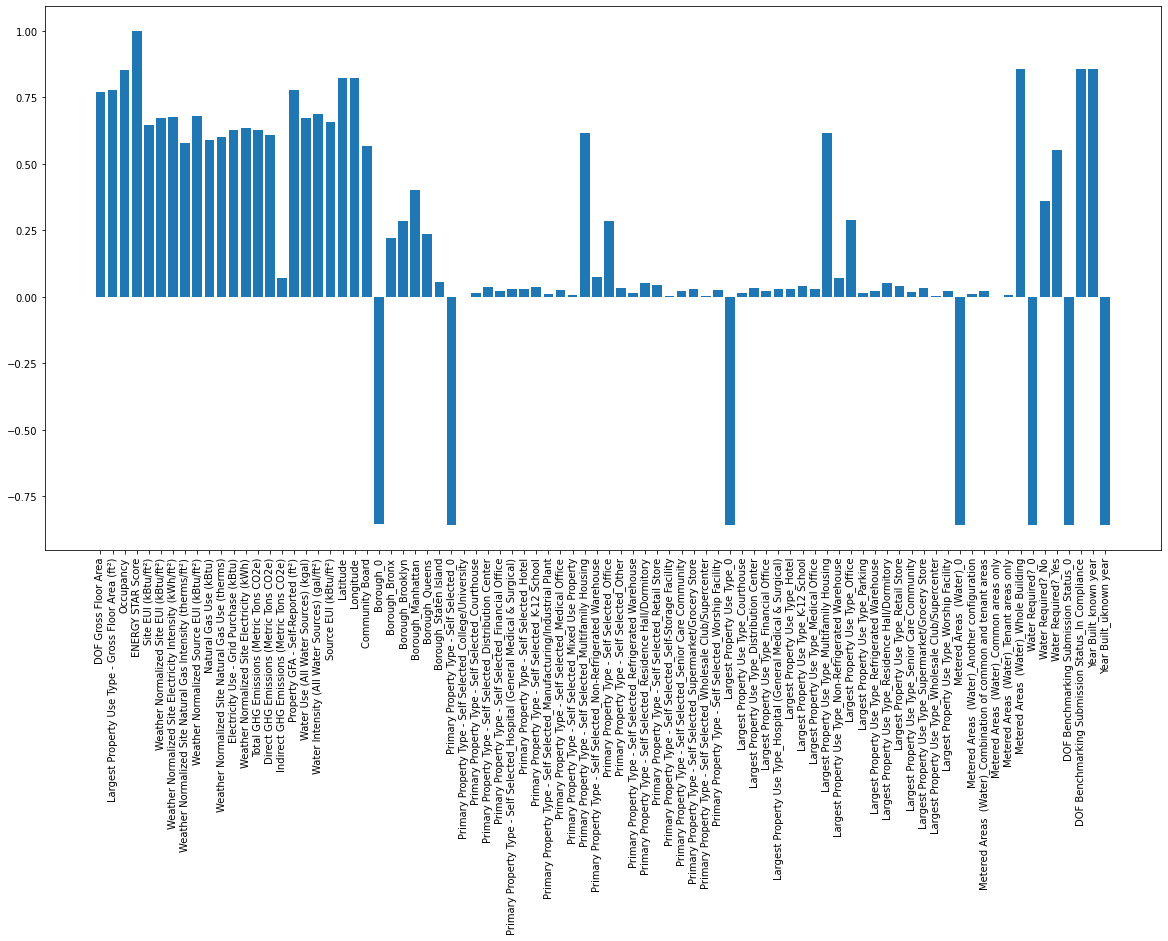

In [21]:
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize(20, 10))
plt.xticks(rotation=90)
plt.bar(top_corr_features, height=list(df[top_corr_features].corr()['ENERGY STAR Score']))

In [22]:
features_dict = df[top_corr_features].corr()['ENERGY STAR Score'].to_dict()
best_features = [i for i,j in zip(features_dict.keys(), features_dict.values()) if j > 0.5]

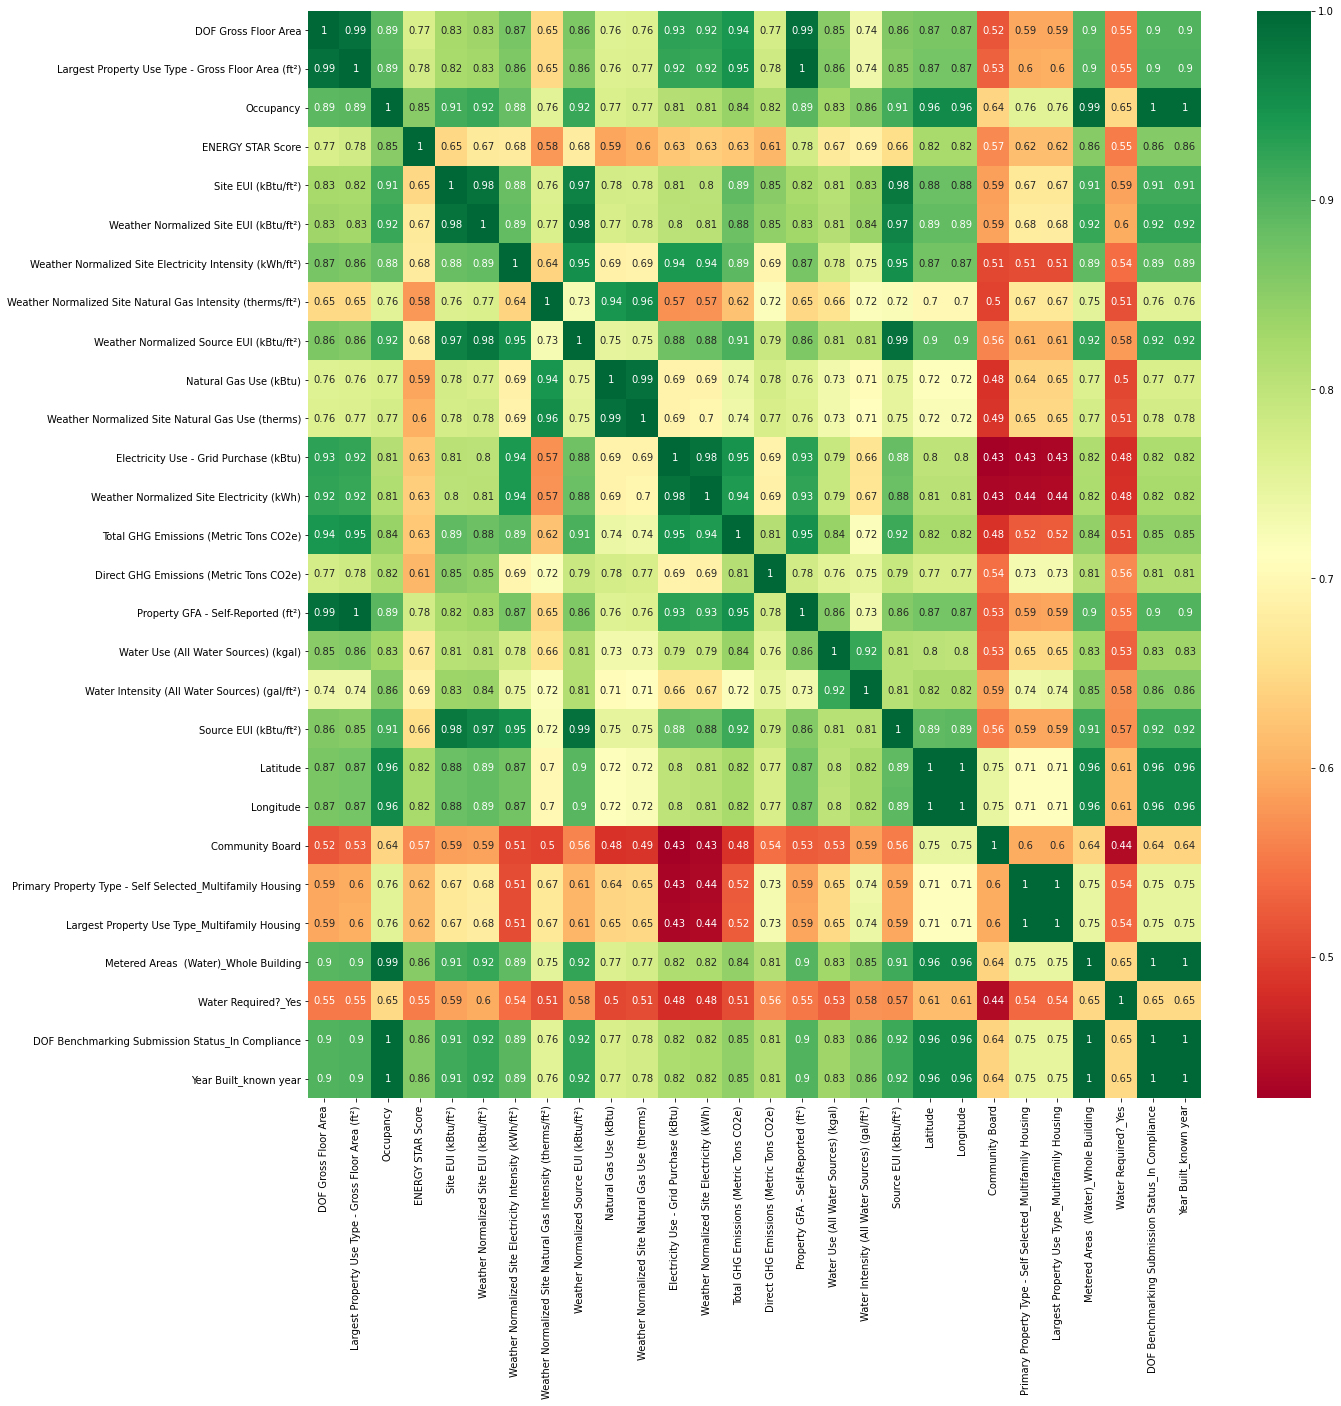

In [23]:
df_with_best_features = df[best_features].corr()
plt.figure(figsize=(20,20))
g=sns.heatmap(df_with_best_features,annot=True,cmap="RdYlGn")

## Top признаков

In [24]:
df_with_best_features.max()

DOF Gross Floor Area                                          1.0
Largest Property Use Type - Gross Floor Area (ft²)            1.0
Occupancy                                                     1.0
ENERGY STAR Score                                             1.0
Site EUI (kBtu/ft²)                                           1.0
Weather Normalized Site EUI (kBtu/ft²)                        1.0
Weather Normalized Site Electricity Intensity (kWh/ft²)       1.0
Weather Normalized Site Natural Gas Intensity (therms/ft²)    1.0
Weather Normalized Source EUI (kBtu/ft²)                      1.0
Natural Gas Use (kBtu)                                        1.0
Weather Normalized Site Natural Gas Use (therms)              1.0
Electricity Use - Grid Purchase (kBtu)                        1.0
Weather Normalized Site Electricity (kWh)                     1.0
Total GHG Emissions (Metric Tons CO2e)                        1.0
Direct GHG Emissions (Metric Tons CO2e)                       1.0
Property G

In [25]:
df = df[best_features]

In [26]:
analyze(df)

Dof Gross Floor Area
~~~~~~~~~~~~~~~~~~~~~~~~~

mean :  2.8167720435163552e-15
var  :  0.9999999999999563
skew :  0.18009298026743092
kurt :  -1.137253183477462
shapiro :  (0.8644128441810608, 0.0)
normaltest :  NormaltestResult(statistic=5119.129191796231, pvalue=0.0)
~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~

Largest Property Use Type - Gross Floor Area (Ft²)
~~~~~~~~~~~~~~~~~~~~~~~~~

mean :  2.705139412039161e-15
var  :  0.9999999999999326
skew :  0.16864968582615356
kurt :  -1.1442777625517524
shapiro :  (0.8639473915100098, 0.0)
normaltest :  NormaltestResult(statistic=5375.781807766553, pvalue=0.0)
~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~

Occupancy
~~~~~~~~~~~~~~~~~~~~~~~~~

mean :  2.5855149251622174e-15
var  :  1.0000000000000089
skew :  -0.44230544200747784
kurt :  -1.7936717878988409
shapiro :  (0.6323193311691284, 0.0)
normaltest :  NormaltestResult(statistic=38543.41649005237, pvalue=0.0)
~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~

Energy Sta

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


normaltest :  NormaltestResult(statistic=43528.689653401714, pvalue=0.0)
~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~

Water Intensity (All Water Sources) (Gal/Ft²)
~~~~~~~~~~~~~~~~~~~~~~~~~

mean :  -2.575818754778083e-16
var  :  1.0000000000000537
skew :  0.19513591433610808
kurt :  -1.3200374266166772
shapiro :  (0.8424791097640991, 0.0)
normaltest :  NormaltestResult(statistic=70795.1672157101, pvalue=0.0)
~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~

Source Eui (Kbtu/Ft²)
~~~~~~~~~~~~~~~~~~~~~~~~~

mean :  -4.105510547114016e-15
var  :  1.0000000000000921
skew :  0.05724442471607967
kurt :  -1.0980575779468809
shapiro :  (0.8371009826660156, 0.0)
normaltest :  NormaltestResult(statistic=3897.1972245518027, pvalue=0.0)
~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~

Latitude
~~~~~~~~~~~~~~~~~~~~~~~~~

mean :  4.021999112879169e-15
var  :  0.9999999999999725
skew :  -0.286265415018079
kurt :  -1.8003920502947328
shapiro :  (0.6940860748291016, 0.0)
normaltest :  N

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: 

# Выделим основную цель и уберем из тренировочного набора

In [27]:
y = df['ENERGY STAR Score']
df = df.drop(['ENERGY STAR Score'],axis=1)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.33, random_state=42)

In [29]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6459, 27)
(3182, 27)
(6459,)
(3182,)


# Алгоритмы

## LR

In [30]:
# создаем параметры LR для перебора в GridSearchCV
parameters_LR = [{'fit_intercept': ['True', 'False']}]

In [31]:
# создаем модель на основее LinearRegression и с помощью GridSearchCV
# подбираем оптимальные параметры и обучаем
LR_FS = GridSearchCV(LinearRegression(), parameters_LR, cv=5)
LR_FS.fit(X_train,y_train)
LR_FS.best_params_

{'fit_intercept': 'True'}

## MAE

In [32]:
np.round(LR_FS.score(X_test,y_test), 2)

0.87

In [33]:
y_pred = LR_FS.predict(X_test)

In [34]:
mae = np.mean(abs(y_pred - y_test))
print('LR: MAE = %0.4f' % mae)

LR: MAE = 0.2187


## Scores

In [35]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

fold = KFold(n_splits=5, shuffle=True, random_state=5)
scores = cross_val_score(estimator = LR_FS, X=X_train, y=y_train,cv=fold)
print('Общее ', scores)
print('Среднее ', scores.mean())
print('Минимальное ',scores.min())
print('Максимальное ', scores.max())


Общее  [0.88856508 0.86090872 0.85834674 0.88348769 0.88603848]
Среднее  0.8754693408368572
Минимальное  0.8583467384591457
Максимальное  0.8885650787791687


## LSVR

In [36]:
# создаем параметры LSVR для перебора в GridSearchCV
parameters_LSVR = [{'epsilon': [0, 0.05, 0.1, 0.5, 1, 4] , 
                          'loss': ['epsilon_insensitive','squared_epsilon_insensitive'], 
                          'fit_intercept': ['True', 'False']}]

In [37]:
# создаем модель на основее LinearSVR и с помощью GridSearchCV
# подбираем оптимальные параметры и обучаем
LSVR = GridSearchCV(LinearSVR(), parameters_LSVR, cv=5)
LSVR.fit(X_train,y_train)
LSVR.best_params_

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

{'epsilon': 0, 'fit_intercept': 'True', 'loss': 'squared_epsilon_insensitive'}

## MAE

In [38]:

np.round(LSVR.score(X_test,y_test), 2)

0.87

In [39]:
y_pred_LSVR = LSVR.predict(X_test)

In [40]:
mae = np.mean(abs(y_pred_LSVR - y_test))
print('LSVR: MAE = %0.4f' % mae)

LSVR: MAE = 0.2195


## Scores

In [41]:
fold = KFold(n_splits=5, shuffle=True, random_state=5)
scores = cross_val_score(estimator = LSVR, X=X_train, y=y_train,cv=fold)
print('Общее ', scores)
print('Сроеднее ', scores.mean())
print('Минимальное ',scores.min())
print('Максимальное ', scores.max())


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

Общее  [0.8884468  0.85980171 0.85830635 0.88358063 0.88673411]
Сроеднее  0.875373920079342
Минимальное  0.8583063485443871
Максимальное  0.8884468028284874


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
